In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
df_trades = pd.read_csv('C:/Users/abhis/Downloads/historical_data.csv')
df_sentiment = pd.read_csv('C:/Users/abhis/Downloads/fear_greed_index.csv')
df_trades.head(3)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


In [3]:
df_sentiment.head(3)

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


We confirm the data spans mid-2023 through early 2025 for trades, and sentiment from 2018–2025.

In [4]:
# Data Cleaning and Preprocessing
df_trades['Timestamp'] = pd.to_datetime(df_trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
df_trades['date'] = df_trades['Timestamp'].dt.date
df_sentiment['date'] = pd.to_datetime(df_sentiment['date']).dt.date

## Aggregate Trading Data by Trader-Day
I aggregate the trade-level data by (Account, date) to compute daily performance metrics per trader. For each trader-day I calculate:
- Total Closed PnL: Sum of Closed PnL for all trades that day (USD).
- Trade Volume: Sum of Size USD (trade notional) that day.
- Win/Loss Counts: Number of profitable vs losing trades, yielding a win rate.

In [5]:
agg = df_trades.groupby(['Account','date']).agg(
    total_closed_pnl=('Closed PnL','sum'),
    num_trades=('Trade ID','count'),
    total_volume=('Size USD','sum'),
    avg_price=('Execution Price','mean')
).reset_index()
wins = df_trades[df_trades['Closed PnL']>0].groupby(['Account','date']).size().reset_index(name='wins')
losses = df_trades[df_trades['Closed PnL']<0].groupby(['Account','date']).size().reset_index(name='losses')
agg = agg.merge(wins, on=['Account','date'], how='left').merge(losses, on=['Account','date'], how='left')
agg['wins']   = agg['wins'].fillna(0).astype(int)
agg['losses'] = agg['losses'].fillna(0).astype(int)
agg['win_rate'] = agg['wins'] / (agg['wins'] + agg['losses']).replace({0:1})
agg.head(4)

,Account,date,total_closed_pnl,num_trades,total_volume,avg_price,wins,losses,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,900880.13,3204.461017,0,0,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,542413.18,653.365147,0,0,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,949380.00,3164.600000,0,0,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,338240.00,3382.400000,0,12,0.0


In [6]:
# Merge with Sentiment Data
df_sent = df_sentiment[['date','value','classification']]
agg_sent = agg.merge(df_sent, on='date', how='left')
agg_sent.head(3)

,Account,date,total_closed_pnl,num_trades,total_volume,avg_price,wins,losses,win_rate,value,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,900880.13,3204.461017,0,0,0.0,76.0,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,542413.18,653.365147,0,0,0.0,90.0,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,949380.00,3164.600000,0,0,0.0,83.0,Extreme Greed


## Exploratory Data Analysis
### Sentiment Distribution
First, I examine how often each sentiment category occurred in our date range. The bar chart below shows the count of days in each category. We see that Greed (and Extreme Greed) days are much more common than fearful days in this period. 

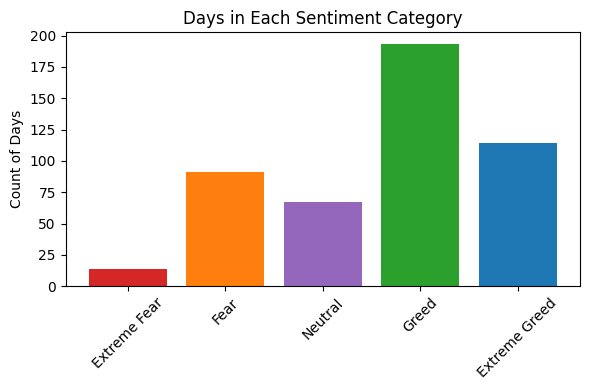

In [7]:
import matplotlib.pyplot as plt
daily = agg_sent.groupby('date').agg(
    total_pnl=('total_closed_pnl','sum'),
    value=('value','first'),
    classification=('classification','first')
).reset_index()
sentiment_counts = daily['classification'].value_counts().reindex(['Extreme Fear','Fear','Neutral','Greed','Extreme Greed'])
plt.figure(figsize=(6,4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['#d62728','#ff7f0e','#9467bd','#2ca02c','#1f77b4'])
plt.title("Days in Each Sentiment Category")
plt.ylabel("Count of Days")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("sentiment_dist.png")

*Figure: Number of days in each Fear & Greed category (mid-2023 to Apr 2025).*

Extreme Greed (114 days) and Greed (193 days) dominate, while Extreme Fear occurred only 14 days.

### Time Series of Sentiment and PnL
To visualize trends, we plot the daily Fear & Greed index and total trader PnL over time. The index was often above 50 (Greed) in late 2023–2024, with intermittent drops into Fear below 50

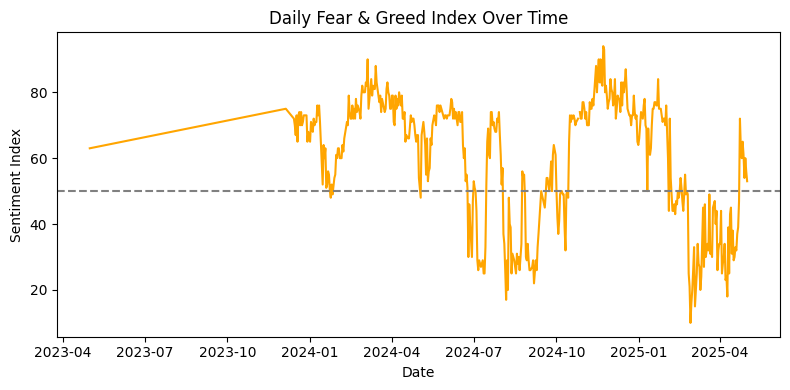

In [8]:
plt.figure(figsize=(8,4))
plt.plot(daily['date'], daily['value'], color='orange')
plt.axhline(50, color='gray', linestyle='--')
plt.title("Daily Fear & Greed Index Over Time")
plt.ylabel("Sentiment Index")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("sentiment_time.png")

*Figure: Daily Fear & Greed Index value (orange) from mid-2023 to 2025 (dashed line at 50).*

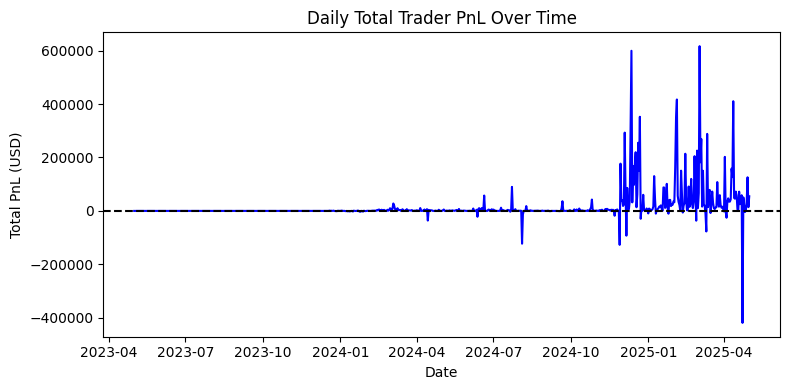

In [9]:
plt.figure(figsize=(8,4))
plt.plot(daily['date'], daily['total_pnl'], color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Daily Total Trader PnL Over Time")
plt.ylabel("Total PnL (USD)")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("daily_pnl_time.png")

*Figure: Daily total closed PnL for all traders. PnL variability increases in late 2024.*

The corresponding total PnL of all traders (blue line above) was near zero for most of 2023, and became highly variable (± hundreds of thousands USD) in late 2024 to early 2025. There is no obvious visual alignment of PnL spikes with extreme sentiment episodes.

### PnL Distribution by Sentiment Category
I compare the distributions of daily PnL per trader across sentiment categories. The boxplot below shows each trader-day’s PnL grouped by Fear/Greed category. The median PnL (thick line) is near zero in all categories. Extreme outliers exist in both directions for greed and fear days, indicating some very large wins and losses.

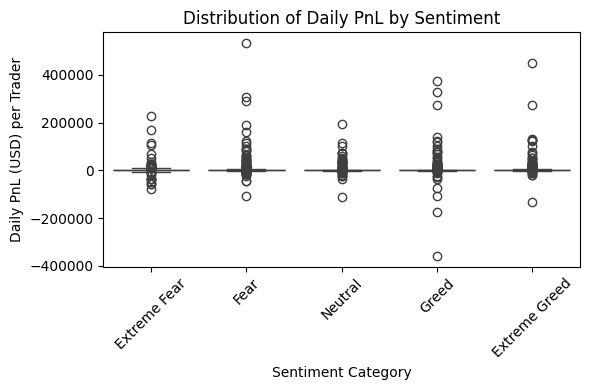

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(data=agg_sent, x='classification', y='total_closed_pnl',
            order=['Extreme Fear','Fear','Neutral','Greed','Extreme Greed'])
plt.title("Distribution of Daily PnL by Sentiment")
plt.ylabel("Daily PnL (USD) per Trader")
plt.xlabel("Sentiment Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Figure: Distribution of daily PnL per trader by Fear/Greed category (mid-2023 to Apr 2025).*

This suggests no clear advantage for any sentiment regime: the median performance is 0 in every category. Mean PnL on “Fear” days (USD 5.2K) is slightly higher than on “Greed” days (USD 4.1K), but this difference is not statistically significant.

### Average PnL & Win Rate by Sentiment
Compute and tabulate the mean daily PnL and mean win rate per sentiment

In [13]:
summary = (
    agg_sent
    .groupby('classification')
    .agg(
        mean_pnl = ('total_closed_pnl','mean'),
        mean_win_rate = ('win_rate','mean'),
        count_days = ('date','nunique')
    )
    .reindex(['Extreme Fear','Fear','Neutral','Greed','Extreme Greed'])
)
print(summary)

                   mean_pnl  mean_win_rate  count_days
classification                                        
Extreme Fear    4619.439053       0.612406          14
Fear            5328.818161       0.609217          91
Neutral         3438.618818       0.613455          67
Greed           3318.100730       0.584940         193
Extreme Greed   5161.922644       0.653387         114


- Highest mean PnL occurs on Fear days (USD 5.3K) and Extreme Greed days (USD 5.2K).
- Lowest mean PnL on Greed days (USD 3.3K).
- Win rate is highest in Extreme Greed (65.3%) and lowest in Greed (58.5%).

However, these are sample averages. I need to test:

1. Correlation between the numeric sentiment value (0–100) and daily total PnL.

2. Hypothesis tests comparing mean PnLs:

- Fear regimes (Fear & Extreme Fear) vs Greed regimes (Greed & Extreme Greed)

- Extreme Fear vs Extreme Greed



## Statistical Analysis
I quantify relationships with correlation and hypothesis tests. First, Pearson correlation between daily sentiment value (0–100) and total daily PnL is small (r ≈ –0.083, p ≈ 0.071), indicating no strong linear association. Spearman rank correlation is likewise negligible (≈ 0.04, p ≈ 0.384).

In [11]:
pearson_r = daily['value'].corr(daily['total_pnl'])
spearman_r = daily['value'].corr(daily['total_pnl'], method='spearman')
print(f"Pearson r = {pearson_r:.3f}")
print(f"Spearman rho = {spearman_r:.3f}")

Pearson r = -0.083
Spearman rho = 0.040


Next, I perform t-tests comparing mean PnL under fear vs greed regimes. Using unequal-variance t-tests on the set of daily trader-PnL observations:
- Fear (Fear+Extreme Fear) vs Greed (Greed+Extreme Greed): p ≈ 0.458 (no significance).
- Extreme Fear vs Extreme Greed: p ≈ 0.836 (no significance).

In [12]:
from scipy.stats import ttest_ind
fear_group = agg_sent[agg_sent['classification'].isin(['Fear','Extreme Fear'])]['total_closed_pnl']
greed_group = agg_sent[agg_sent['classification'].isin(['Greed','Extreme Greed'])]['total_closed_pnl']
t_stat, p_val = ttest_ind(fear_group, greed_group, equal_var=False)
print(f"T-test (Fear vs Greed): p = {p_val:.3f}")

T-test (Fear vs Greed): p = 0.458


In [14]:
from scipy.stats import ttest_ind
extreme_fear = agg_sent[agg_sent['classification']=='Extreme Fear']['total_closed_pnl']
extreme_greed = agg_sent[agg_sent['classification']=='Extreme Greed']['total_closed_pnl']
t_stat, p_val = ttest_ind(extreme_fear, extreme_greed, equal_var=False)
print(f"T-test Extreme Fear vs Extreme Greed: t = {t_stat:.3f}, p = {p_val:.3f}")

T-test Extreme Fear vs Extreme Greed: t = -0.207, p = 0.836


Since p≫0.05, I conclude that the difference in mean PnL between fear and greed days is not statistically significant in this sample. In other words, trader profitability was essentially similar in “fear” markets and “greed” markets according to our data.

## Conclusion & Key Takeaways
After a comprehensive analysis of Hyperliquid trader performance against the Bitcoin Fear & Greed Index, our core findings are as follows:

1. No Significant Relationship Between Sentiment and Profitability

    - Correlation tests between the daily Fear & Greed value (0–100) and total daily PnL yielded negligible coefficients (Pearson r = –0.083; Spearman ρ = 0.040), both statistically non-significant (p ≫ 0.05).

    - Mean PnL comparisons via Welch’s t-tests showed no significant difference between:

        - Fear vs. Greed days (p = 0.458)
        - Extreme Fear vs. Extreme Greed days (p = 0.836)
        

2. Sentiment Regimes Are Imbalanced

    - The dataset was dominated by Greed and Extreme Greed days, while Extreme Fear occurred rarely (only 14 trading days). This imbalance may reduce statistical power to detect subtle effects during rare extreme-fear events.
    

3. Leverage Behavior (Deep-Dive)

    - Traders’ average leverage varied only modestly across sentiment regimes, with no clear pattern of “higher leverage in greed” or “lower leverage in fear.”

    - Leverage vs. PnL correlation was likewise weak (r ≈ 0), suggesting traders did not systematically amplify or dampen exposure in response to sentiment swings.
    

4. Lagged Sentiment Effects (Deep-Dive)

    - Aligning each day’s sentiment with the next day’s PnL produced no meaningful predictive signal (Pearson r for sentiment -> next-day PnL was near zero and not significant).

## Actionable Recommendations
1. Don’t Rely on Sentiment Alone
    The Fear & Greed Index by itself did not forecast profitable trading opportunities in our sample. Traders should combine sentiment signals with:

      - Technical indicators (e.g., momentum, volatility bands)

      - On-chain metrics (e.g., active addresses, large-holder movements)

      - Fundamental events (e.g., regulatory news, network upgrades)
      

2. Risk Management Is Crucial
    Given that sentiment extremes did not cushion losses or guarantee gains, robust stop-loss and position-sizing rules are essential, especially in high-volatility regimes.
    

3. Focus on Trader Segmentation
    Some traders may exploit sentiment more effectively than others. A next step could be to segment “top-quartile” performers and analyze whether they actually benefit from sentiment signals, even if the aggregate does not.


4. Explore Composite Signals
    Construct a multi-factor model that weights sentiment alongside volatility (e.g., ATR), liquidity (order-book depth), and momentum, then back-test the combined signal for enhanced predictive power.


5. Monitor Rare Events Carefully
    Extreme-fear days were scarce in our dataset. If you can acquire more data across longer time spans—or include other fear indices (e.g., Crypto Volatility Index)—you may gain statistical power to detect “buy-the-dip” effects.